In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
data.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed','annual_income', 'interaction_count', 'lead_score']


In [7]:
data[numerical].isna().sum()

,0
number_of_courses_viewed,0
annual_income,181
interaction_count,0
lead_score,0


In [8]:
data[numerical] = data[numerical].fillna(0)

In [9]:
data[categorical].isna().sum()

,0
lead_source,128
industry,134
employment_status,100
location,63


In [10]:
data[categorical] = data[categorical].fillna('NA')

In [11]:
data.isna().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [12]:
from sklearn.model_selection import train_test_split

Y = data['converted']
X = data.drop('converted', axis=1)

# First split: train_full vs test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1
)

# Second split: train vs validation (from the training portion)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=1
)

In [13]:
from sklearn.metrics import roc_auc_score

for col in numerical:
  print(col)
  y_pred = X_train[col]
  auc = roc_auc_score(y_train, y_pred)
  print("AUC: ", auc)
  print()
  print()

number_of_courses_viewed
AUC:  0.7635680590007088


annual_income
AUC:  0.5519578313253012


interaction_count
AUC:  0.738270176293409


lead_score
AUC:  0.6144993577250176




In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [15]:
y_pred = model.predict(X_val)
score = roc_auc_score(y_val, y_pred)
print(round(score,3))


0.648


In [16]:
from sklearn.metrics import precision_score, recall_score
thresholds = np.linspace(0, 1, 101)

probs = model.predict_proba(X_val)[:, 1]
precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    precision = precision_score(y_val, preds, zero_division=0)
    recall = recall_score(y_val, preds, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)


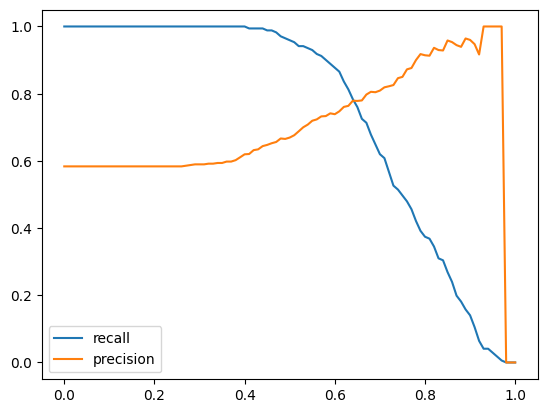

In [17]:
import matplotlib.pyplot as plt


plt.plot(thresholds, recalls, label = 'recall')
plt.plot(thresholds, precisions, label = 'precision')
plt.legend()

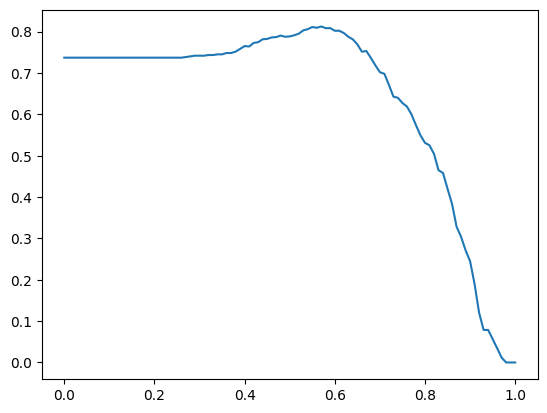

In [19]:
f1 = []
for precision, recall in zip(precisions, recalls):
  try:
    f = 2* (precision*recall)/(precision+recall)
  except:
    f = 0
  f1.append(f)

plt.plot(thresholds,f1)

In [21]:
np.argmax(f1)

np.int64(57)

In [23]:
thresholds[57]

np.float64(0.5700000000000001)

In [34]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


from sklearn.model_selection import KFold




In [37]:
df_train, df_test = train_test_split(
    data, test_size=0.2, random_state=1
)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_train):
    df_train_fold = df_train.iloc[train_idx]
    df_val_fold = df_train.iloc[val_idx]

    y_train = df_train_fold['converted'].values
    y_val = df_val_fold['converted'].values

    dv, model = train(df_train_fold, y_train)
    y_pred = predict(df_val_fold, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(np.std(scores))

0.03580711942905165


In [43]:
def training(df_train, y_train, c):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [45]:
from tqdm import tqdm

n_splits = 5
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        df_train_fold = df_train.iloc[train_idx]
        df_val_fold = df_train.iloc[val_idx]

        y_train = df_train_fold.converted.values
        y_val = df_val_fold.converted.values

        dv, model = training(df_train_fold, y_train, c=C)
        y_pred = predict(df_val_fold, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print()
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 67%|██████▋   | 2/3 [00:00<00:00,  9.65it/s]


C=1e-06 0.560 +- 0.024

C=0.001 0.867 +- 0.029


100%|██████████| 3/3 [00:00<00:00,  9.38it/s]


C=1 0.822 +- 0.036
